# Car Classification Model Training

This notebook trains a Hybrid ResNet-ViT model for Indonesian car classification using the collected dataset. The model combines ResNet-50 as a feature extractor with a Vision Transformer for classification.

## Dataset Structure
- **Classes**: 8 Indonesian car types (hatchback, mpv, offroad, pickup, sedan, suv, truck, van)
- **Architecture**: Hybrid ResNet-ViT combining CNN and Transformer
- **Training Strategy**: Transfer learning with data augmentation
- **Class Imbalance**: Handled using weighted loss function for better minority class performance

## Training Process
1. Dataset exploration and class imbalance analysis
2. Model training with weighted loss and comprehensive tracking
3. Performance analysis with detailed charts and metrics
4. Model evaluation with per-class analysis and confusion matrix
5. Training insights and recommendations for optimization

In [1]:
!rm -rf code data_processing logs models code state.db
!rm 1_run_scraper_into_dataset.ipynb 2_train_the_classification_model.ipynb requirements.txt

In [2]:
!git clone -b feat/pretrained-model https://github.com/luthfiarifin/hybrid-envit-car-retrieval.git code
!mv code/* .
!ls

Cloning into 'code'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 101 (delta 0), reused 2 (delta 0), pack-reused 96 (from 2)
Receiving objects: 100% (101/101), 332.94 MiB | 19.68 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Updating files: 100% (35/35), done.
1_run_scraper_into_dataset.ipynb	code		 models
2_train_the_classification_model.ipynb	data_processing  requirements.txt


In [3]:
IS_IMPORT_FROM_KAGGLE = True

if IS_IMPORT_FROM_KAGGLE:
    import kagglehub
    DATASET_DIR = kagglehub.dataset_download("muhammadluthfiarifin/indonesian-cars-classification-dataset", path="dataset")
else:
    DATASET_DIR = "data_processing/data/dataset"

In [4]:
# Import required libraries

import torch
import time
from datetime import datetime

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(
        f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB"
    )

Libraries imported successfully!
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB
CUDA memory: 15.9 GB


2025-06-23 21:08:40.421089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750712920.443603     324 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750712920.450524     324 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


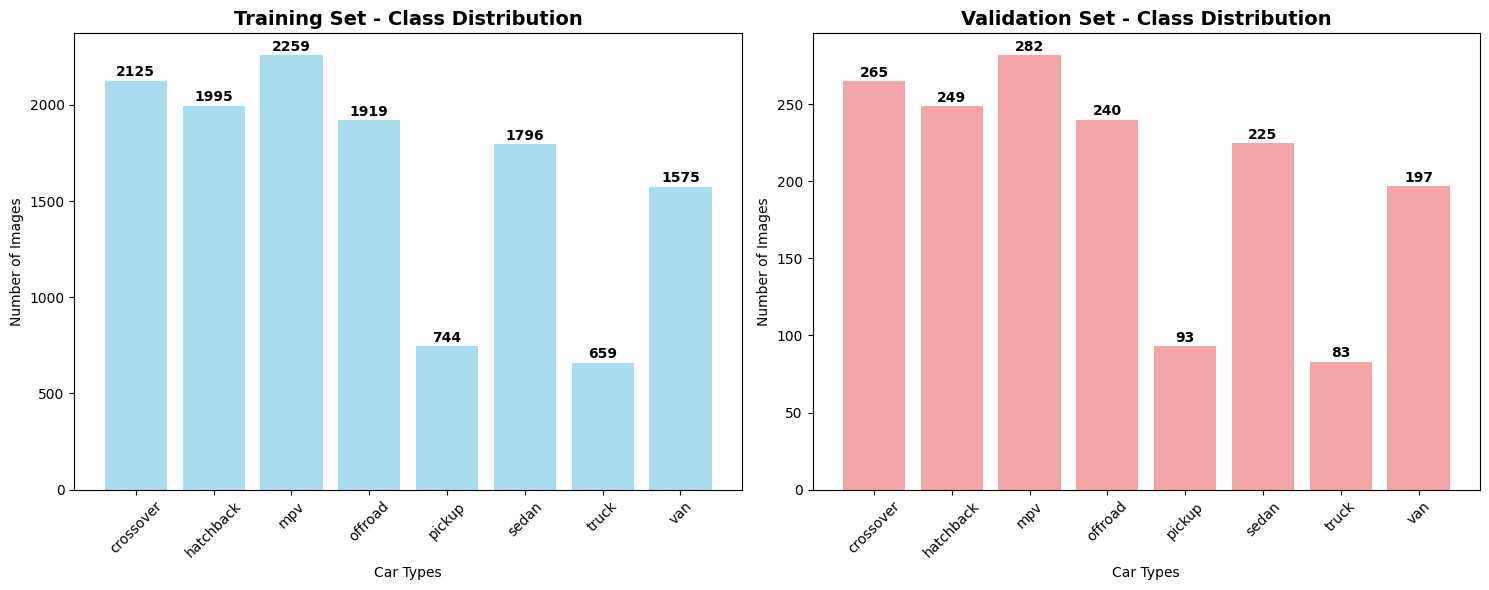


=== Initializing Trainer with Class Imbalance Handling & Early Stopping ===
Using device: cuda
Logging to TensorBoard: logs/train_classification/run_1750712926
Loading pre-trained weights for the Hybrid Model's CNN stem.
Using weighted CrossEntropyLoss with weights: tensor([0.7689, 0.8190, 0.7233, 0.8515, 2.1962, 0.9098, 2.4795, 1.0375],
       device='cuda:0')

📊 Class Distribution Analysis:
Class        Count    Percentage Imbalance Ratio
--------------------------------------------------
crossover    2125     16.3      % 1.06           x
hatchback    1995     15.3      % 1.13           x
mpv          2259     17.3      % 1.00           x
offroad      1919     14.7      % 1.18           x
pickup       744      5.7       % 3.04           x
sedan        1796     13.7      % 1.26           x
truck        659      5.0       % 3.43           x
van          1575     12.0      % 1.43           x

📈 Imbalance Factor: 3.43x (Most frequent / Least frequent)
⚠️  Moderate imbalance detected. We

In [ ]:
# Training configuration

from models.classification.train_classification import CarClassifierTrainer
from models.classification.train_classification_eval import DatasetExplorer


CONFIG = {
    "train_dir": f"{DATASET_DIR}/train",
    "val_dir": f"{DATASET_DIR}/val",
    "num_classes": 8,
    "learning_rate": 1e-4,
    "batch_size": 96,
    "num_epochs": 50,
    "result_path": f'models/classification/results/carvit_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth',
    "use_weighted_loss": True,
    "use_class_balancing": False,
    "num_workers": 12,
    "early_stopping_patience": 7,
    "early_stopping_delta": 0.001,
    "early_stopping_verbose": True,
    "pretrained": True,
}

# Generate and summary report
explorer = DatasetExplorer(
    train_dir=CONFIG["train_dir"],
    val_dir=CONFIG["val_dir"],
)
explorer.summary_report()

# Initialize the trainer
print("\n=== Initializing Trainer with Class Imbalance Handling & Early Stopping ===")
trainer = CarClassifierTrainer(
    train_dir=CONFIG["train_dir"],
    val_dir=CONFIG["val_dir"],
    num_classes=CONFIG["num_classes"],
    learning_rate=CONFIG["learning_rate"],
    batch_size=CONFIG["batch_size"],
    num_epochs=CONFIG["num_epochs"],
    result_path=CONFIG["result_path"],
    use_weighted_loss=CONFIG["use_weighted_loss"],
    use_class_balancing=CONFIG["use_class_balancing"],
    num_workers=CONFIG["num_workers"],
    early_stopping_patience=CONFIG["early_stopping_patience"],
    early_stopping_delta=CONFIG["early_stopping_delta"],
    early_stopping_verbose=CONFIG["early_stopping_verbose"],
    pretrained=CONFIG["pretrained"],
)

print("Trainer initialized successfully!")
print(f"Training samples: {len(trainer.train_dataset)}")
print(f"Validation samples: {len(trainer.val_dataset)}")
print(f"Number of batches per epoch: {len(trainer.train_loader)}")
print(f"Class names: {trainer.train_dataset.classes}")

In [6]:
# Start training with detailed tracking
start_time = time.time()

# Execute training
training_results = trainer.train()

# Print training results
total_time = time.time() - start_time
print(f"\n=== Training Completed in {total_time:.2f} seconds ===")

Starting training with detailed tracking and early stopping...
Early Stopping - Patience: 7, Delta: 0.001
Model parameters: 21,767,852
Trainable parameters: 21,767,852

Epoch 1/50


100%|██████████| 137/137 [02:06<00:00,  1.08it/s, loss=1.66]


Validation accuracy: 27.11%
Validation loss: 1.8677
Train Loss: 2.0284 | Train Acc: 16.67%
Val Loss: 1.8677 | Val Acc: 27.11%
Time: 135.11s | LR: 1.00e-04
🎉 New best accuracy: 27.11%
Validation loss decreased (inf --> 1.867720).  Saving model ...

Epoch 2/50


100%|██████████| 137/137 [02:07<00:00,  1.08it/s, loss=2.07]


Validation accuracy: 33.78%
Validation loss: 1.6928
Train Loss: 1.8469 | Train Acc: 24.89%
Val Loss: 1.6928 | Val Acc: 33.78%
Time: 135.20s | LR: 1.00e-04
🎉 New best accuracy: 33.78%
Validation loss decreased (1.867720 --> 1.692780).  Saving model ...

Epoch 3/50


100%|██████████| 137/137 [02:06<00:00,  1.08it/s, loss=2.05]


Validation accuracy: 39.29%
Validation loss: 1.5684
Train Loss: 1.7092 | Train Acc: 30.22%
Val Loss: 1.5684 | Val Acc: 39.29%
Time: 134.32s | LR: 1.00e-04
🎉 New best accuracy: 39.29%
Validation loss decreased (1.692780 --> 1.568439).  Saving model ...

Epoch 4/50


100%|██████████| 137/137 [02:07<00:00,  1.08it/s, loss=1.9] 


Validation accuracy: 46.08%
Validation loss: 1.4503
Train Loss: 1.5830 | Train Acc: 36.14%
Val Loss: 1.4503 | Val Acc: 46.08%
Time: 134.91s | LR: 1.00e-04
🎉 New best accuracy: 46.08%
Validation loss decreased (1.568439 --> 1.450278).  Saving model ...

Epoch 5/50


100%|██████████| 137/137 [02:07<00:00,  1.08it/s, loss=1.21]


Validation accuracy: 49.08%
Validation loss: 1.3823
Train Loss: 1.4723 | Train Acc: 40.69%
Val Loss: 1.3823 | Val Acc: 49.08%
Time: 135.10s | LR: 1.00e-04
🎉 New best accuracy: 49.08%
Validation loss decreased (1.450278 --> 1.382260).  Saving model ...

Epoch 6/50


100%|██████████| 137/137 [02:07<00:00,  1.07it/s, loss=1.93]


Validation accuracy: 52.51%
Validation loss: 1.3036
Train Loss: 1.3771 | Train Acc: 44.91%
Val Loss: 1.3036 | Val Acc: 52.51%
Time: 135.56s | LR: 1.00e-04
🎉 New best accuracy: 52.51%
Validation loss decreased (1.382260 --> 1.303604).  Saving model ...

Epoch 7/50


100%|██████████| 137/137 [02:07<00:00,  1.07it/s, loss=1.09] 


Validation accuracy: 57.34%
Validation loss: 1.1526
Train Loss: 1.2748 | Train Acc: 49.58%
Val Loss: 1.1526 | Val Acc: 57.34%
Time: 135.63s | LR: 1.00e-04
🎉 New best accuracy: 57.34%
Validation loss decreased (1.303604 --> 1.152611).  Saving model ...

Epoch 8/50


100%|██████████| 137/137 [02:08<00:00,  1.07it/s, loss=1.18] 


Validation accuracy: 59.49%
Validation loss: 1.2381
Train Loss: 1.1881 | Train Acc: 52.82%
Val Loss: 1.2381 | Val Acc: 59.49%
Time: 135.74s | LR: 1.00e-04
🎉 New best accuracy: 59.49%
EarlyStopping counter: 1 out of 7

Epoch 9/50


100%|██████████| 137/137 [02:10<00:00,  1.05it/s, loss=1.09] 


Validation accuracy: 62.18%
Validation loss: 1.1240
Train Loss: 1.1205 | Train Acc: 55.66%
Val Loss: 1.1240 | Val Acc: 62.18%
Time: 137.56s | LR: 1.00e-04
🎉 New best accuracy: 62.18%
Validation loss decreased (1.152611 --> 1.124009).  Saving model ...

Epoch 10/50


100%|██████████| 137/137 [02:07<00:00,  1.07it/s, loss=1.11] 


Validation accuracy: 65.91%
Validation loss: 0.9854
Train Loss: 1.0443 | Train Acc: 58.60%
Val Loss: 0.9854 | Val Acc: 65.91%
Time: 135.56s | LR: 1.00e-04
🎉 New best accuracy: 65.91%
Validation loss decreased (1.124009 --> 0.985396).  Saving model ...

Epoch 11/50


100%|██████████| 137/137 [02:07<00:00,  1.07it/s, loss=0.711]


Validation accuracy: 67.50%
Validation loss: 0.9207
Train Loss: 0.9705 | Train Acc: 61.77%
Val Loss: 0.9207 | Val Acc: 67.50%
Time: 135.60s | LR: 1.00e-04
🎉 New best accuracy: 67.50%
Validation loss decreased (0.985396 --> 0.920702).  Saving model ...

Epoch 12/50


100%|██████████| 137/137 [02:08<00:00,  1.06it/s, loss=0.853]


Validation accuracy: 67.69%
Validation loss: 0.8972
Train Loss: 0.9160 | Train Acc: 63.70%
Val Loss: 0.8972 | Val Acc: 67.69%
Time: 136.74s | LR: 1.00e-04
🎉 New best accuracy: 67.69%
Validation loss decreased (0.920702 --> 0.897192).  Saving model ...

Epoch 13/50


100%|██████████| 137/137 [02:10<00:00,  1.05it/s, loss=1.17] 


Validation accuracy: 71.42%
Validation loss: 0.8729
Train Loss: 0.8651 | Train Acc: 66.03%
Val Loss: 0.8729 | Val Acc: 71.42%
Time: 138.12s | LR: 1.00e-04
🎉 New best accuracy: 71.42%
Validation loss decreased (0.897192 --> 0.872866).  Saving model ...

Epoch 14/50


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, loss=0.799]


Validation accuracy: 71.18%
Validation loss: 0.8418
Train Loss: 0.8099 | Train Acc: 68.64%
Val Loss: 0.8418 | Val Acc: 71.18%
Time: 133.59s | LR: 1.00e-04
Validation loss decreased (0.872866 --> 0.841766).  Saving model ...

Epoch 15/50


100%|██████████| 137/137 [02:06<00:00,  1.08it/s, loss=0.707]


Validation accuracy: 73.56%
Validation loss: 0.8611
Train Loss: 0.7547 | Train Acc: 70.33%
Val Loss: 0.8611 | Val Acc: 73.56%
Time: 134.13s | LR: 1.00e-04
🎉 New best accuracy: 73.56%
EarlyStopping counter: 1 out of 7

Epoch 16/50


100%|██████████| 137/137 [02:06<00:00,  1.09it/s, loss=0.545]


Validation accuracy: 73.07%
Validation loss: 0.8205
Train Loss: 0.7270 | Train Acc: 71.21%
Val Loss: 0.8205 | Val Acc: 73.07%
Time: 133.81s | LR: 1.00e-04
Validation loss decreased (0.841766 --> 0.820532).  Saving model ...

Epoch 17/50


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, loss=0.353]


Validation accuracy: 74.24%
Validation loss: 0.7623
Train Loss: 0.6685 | Train Acc: 73.78%
Val Loss: 0.7623 | Val Acc: 74.24%
Time: 133.03s | LR: 1.00e-04
🎉 New best accuracy: 74.24%
Validation loss decreased (0.820532 --> 0.762312).  Saving model ...

Epoch 18/50


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, loss=0.394]


Validation accuracy: 75.03%
Validation loss: 0.8580
Train Loss: 0.6389 | Train Acc: 74.26%
Val Loss: 0.8580 | Val Acc: 75.03%
Time: 133.20s | LR: 1.00e-04
🎉 New best accuracy: 75.03%
EarlyStopping counter: 1 out of 7

Epoch 19/50


100%|██████████| 137/137 [02:06<00:00,  1.09it/s, loss=1.41] 


Validation accuracy: 75.34%
Validation loss: 0.7163
Train Loss: 0.6010 | Train Acc: 76.06%
Val Loss: 0.7163 | Val Acc: 75.34%
Time: 133.86s | LR: 1.00e-04
🎉 New best accuracy: 75.34%
Validation loss decreased (0.762312 --> 0.716258).  Saving model ...

Epoch 20/50


100%|██████████| 137/137 [02:06<00:00,  1.09it/s, loss=0.61] 


Validation accuracy: 77.42%
Validation loss: 0.7495
Train Loss: 0.6058 | Train Acc: 76.84%
Val Loss: 0.7495 | Val Acc: 77.42%
Time: 133.53s | LR: 1.00e-04
🎉 New best accuracy: 77.42%
EarlyStopping counter: 1 out of 7

Epoch 21/50


100%|██████████| 137/137 [02:06<00:00,  1.09it/s, loss=0.547]


Validation accuracy: 75.76%
Validation loss: 0.7261
Train Loss: 0.5473 | Train Acc: 78.48%
Val Loss: 0.7261 | Val Acc: 75.76%
Time: 133.64s | LR: 1.00e-04
EarlyStopping counter: 2 out of 7

Epoch 22/50


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, loss=1.16] 


Validation accuracy: 78.03%
Validation loss: 0.7695
Train Loss: 0.5390 | Train Acc: 78.57%
Val Loss: 0.7695 | Val Acc: 78.03%
Time: 133.33s | LR: 1.00e-04
🎉 New best accuracy: 78.03%
EarlyStopping counter: 3 out of 7

Epoch 23/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=0.545]


Validation accuracy: 76.50%
Validation loss: 0.7456
Train Loss: 0.4994 | Train Acc: 80.22%
Val Loss: 0.7456 | Val Acc: 76.50%
Time: 132.23s | LR: 1.00e-04
EarlyStopping counter: 4 out of 7

Epoch 24/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=0.849]


Validation accuracy: 77.36%
Validation loss: 0.7776
Train Loss: 0.4899 | Train Acc: 80.27%
Val Loss: 0.7776 | Val Acc: 77.36%
Time: 132.54s | LR: 1.00e-04
EarlyStopping counter: 5 out of 7

Epoch 25/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=0.454]


Validation accuracy: 76.99%
Validation loss: 0.7927
Train Loss: 0.4728 | Train Acc: 81.00%
Val Loss: 0.7927 | Val Acc: 76.99%
Time: 132.74s | LR: 1.00e-04
EarlyStopping counter: 6 out of 7

Epoch 26/50


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, loss=0.614]


Validation accuracy: 77.72%
Validation loss: 0.7672
Train Loss: 0.4261 | Train Acc: 82.86%
Val Loss: 0.7672 | Val Acc: 77.72%
Time: 133.42s | LR: 1.00e-04
EarlyStopping counter: 1 out of 7

Epoch 28/50


100%|██████████| 137/137 [02:06<00:00,  1.08it/s, loss=0.542]


Validation accuracy: 79.38%
Validation loss: 0.6903
Train Loss: 0.4123 | Train Acc: 83.54%
Val Loss: 0.6903 | Val Acc: 79.38%
Time: 134.68s | LR: 1.00e-04
Validation loss decreased (0.696624 --> 0.690320).  Saving model ...

Epoch 29/50


100%|██████████| 137/137 [02:07<00:00,  1.07it/s, loss=0.239]


Validation accuracy: 78.21%
Validation loss: 0.8228
Train Loss: 0.3908 | Train Acc: 83.96%
Val Loss: 0.8228 | Val Acc: 78.21%
Time: 135.51s | LR: 1.00e-04
EarlyStopping counter: 1 out of 7

Epoch 30/50


100%|██████████| 137/137 [02:10<00:00,  1.05it/s, loss=0.304]


Validation accuracy: 78.52%
Validation loss: 0.7472
Train Loss: 0.3815 | Train Acc: 84.61%
Val Loss: 0.7472 | Val Acc: 78.52%
Time: 138.15s | LR: 1.00e-04
EarlyStopping counter: 2 out of 7

Epoch 31/50


100%|██████████| 137/137 [02:08<00:00,  1.07it/s, loss=0.568]


Validation accuracy: 78.95%
Validation loss: 0.7311
Train Loss: 0.3655 | Train Acc: 85.35%
Val Loss: 0.7311 | Val Acc: 78.95%
Time: 136.30s | LR: 1.00e-04
EarlyStopping counter: 3 out of 7

Epoch 32/50


100%|██████████| 137/137 [02:09<00:00,  1.06it/s, loss=0.47] 


Validation accuracy: 79.07%
Validation loss: 0.7807
Train Loss: 0.3639 | Train Acc: 85.14%
Val Loss: 0.7807 | Val Acc: 79.07%
Time: 137.27s | LR: 1.00e-04
EarlyStopping counter: 4 out of 7

Epoch 33/50


100%|██████████| 137/137 [02:12<00:00,  1.04it/s, loss=0.286]


Validation accuracy: 79.44%
Validation loss: 0.7214
Train Loss: 0.3416 | Train Acc: 86.16%
Val Loss: 0.7214 | Val Acc: 79.44%
Time: 140.24s | LR: 1.00e-04
EarlyStopping counter: 5 out of 7

Epoch 34/50


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, loss=0.311]


Validation accuracy: 79.99%
Validation loss: 0.7363
Train Loss: 0.3440 | Train Acc: 85.78%
Val Loss: 0.7363 | Val Acc: 79.99%
Time: 133.24s | LR: 1.00e-04
🎉 New best accuracy: 79.99%
EarlyStopping counter: 6 out of 7

Epoch 35/50


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, loss=0.664]


Validation accuracy: 80.05%
Validation loss: 0.6622
Train Loss: 0.3334 | Train Acc: 86.74%
Val Loss: 0.6622 | Val Acc: 80.05%
Time: 132.63s | LR: 1.00e-04
🎉 New best accuracy: 80.05%
Validation loss decreased (0.690320 --> 0.662226).  Saving model ...

Epoch 36/50


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, loss=0.117]


Validation accuracy: 80.17%
Validation loss: 0.6516
Train Loss: 0.3136 | Train Acc: 87.16%
Val Loss: 0.6516 | Val Acc: 80.17%
Time: 133.38s | LR: 1.00e-04
🎉 New best accuracy: 80.17%
Validation loss decreased (0.662226 --> 0.651589).  Saving model ...

Epoch 37/50


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, loss=0.235]


Validation accuracy: 79.01%
Validation loss: 0.6979
Train Loss: 0.3124 | Train Acc: 87.21%
Val Loss: 0.6979 | Val Acc: 79.01%
Time: 133.60s | LR: 1.00e-04
EarlyStopping counter: 1 out of 7

Epoch 38/50


100%|██████████| 137/137 [02:06<00:00,  1.09it/s, loss=0.347]


Validation accuracy: 80.29%
Validation loss: 0.6526
Train Loss: 0.3025 | Train Acc: 87.74%
Val Loss: 0.6526 | Val Acc: 80.29%
Time: 133.87s | LR: 1.00e-04
🎉 New best accuracy: 80.29%
EarlyStopping counter: 2 out of 7

Epoch 39/50


100%|██████████| 137/137 [02:06<00:00,  1.09it/s, loss=0.249]


Validation accuracy: 80.05%
Validation loss: 0.6550
Train Loss: 0.3091 | Train Acc: 87.51%
Val Loss: 0.6550 | Val Acc: 80.05%
Time: 133.77s | LR: 1.00e-04
EarlyStopping counter: 3 out of 7

Epoch 40/50


100%|██████████| 137/137 [02:09<00:00,  1.06it/s, loss=0.45] 


Validation accuracy: 78.95%
Validation loss: 0.6740
Train Loss: 0.2904 | Train Acc: 88.07%
Val Loss: 0.6740 | Val Acc: 78.95%
Time: 137.16s | LR: 1.00e-04
EarlyStopping counter: 4 out of 7

Epoch 41/50


100%|██████████| 137/137 [02:09<00:00,  1.06it/s, loss=0.657]


Validation accuracy: 78.70%
Validation loss: 0.7373
Train Loss: 0.2856 | Train Acc: 88.49%
Val Loss: 0.7373 | Val Acc: 78.70%
Time: 137.28s | LR: 1.00e-04
EarlyStopping counter: 5 out of 7

Epoch 42/50


100%|██████████| 137/137 [02:10<00:00,  1.05it/s, loss=0.409]


Validation accuracy: 80.17%
Validation loss: 0.6757
Train Loss: 0.2970 | Train Acc: 87.98%
Val Loss: 0.6757 | Val Acc: 80.17%
Time: 138.88s | LR: 1.00e-04
EarlyStopping counter: 6 out of 7

Epoch 43/50


100%|██████████| 137/137 [02:10<00:00,  1.05it/s, loss=0.281]


Validation accuracy: 79.44%
Validation loss: 0.6886
Train Loss: 0.2831 | Train Acc: 88.23%
Val Loss: 0.6886 | Val Acc: 79.44%
Time: 138.60s | LR: 1.00e-04
EarlyStopping counter: 7 out of 7

🛑 Early stopping triggered at epoch 43
Best validation loss: 0.651589

Training completed!
Training stopped early at epoch 43 due to no improvement in validation loss
Best validation accuracy: 80.29%
Loading best model with validation loss: 0.651589
Best accuracy model saved to models/classification/results/carvit_model_20250623_210845_best_acc.pth

=== Training Completed in 5809.34 seconds ===


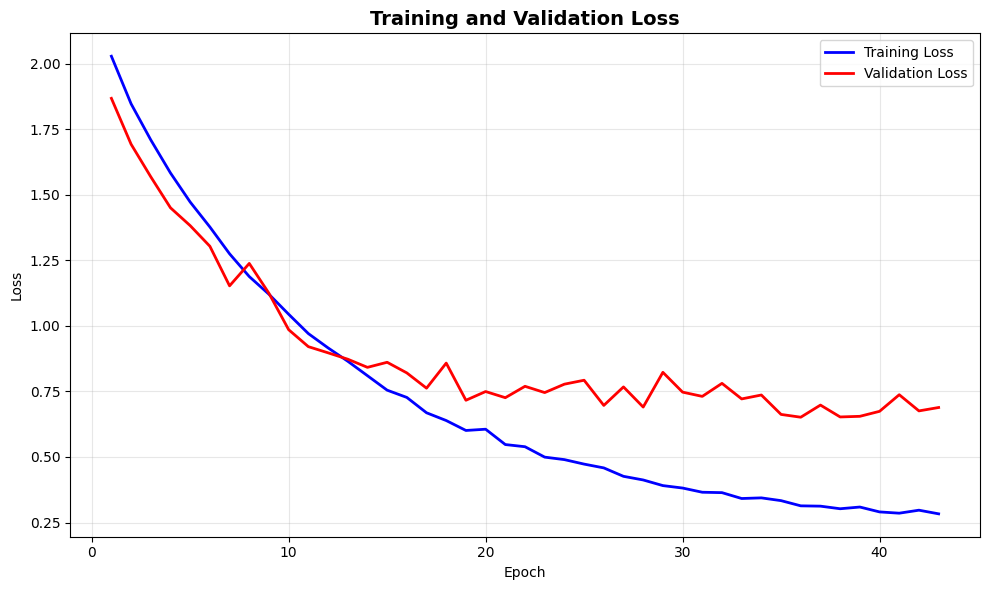

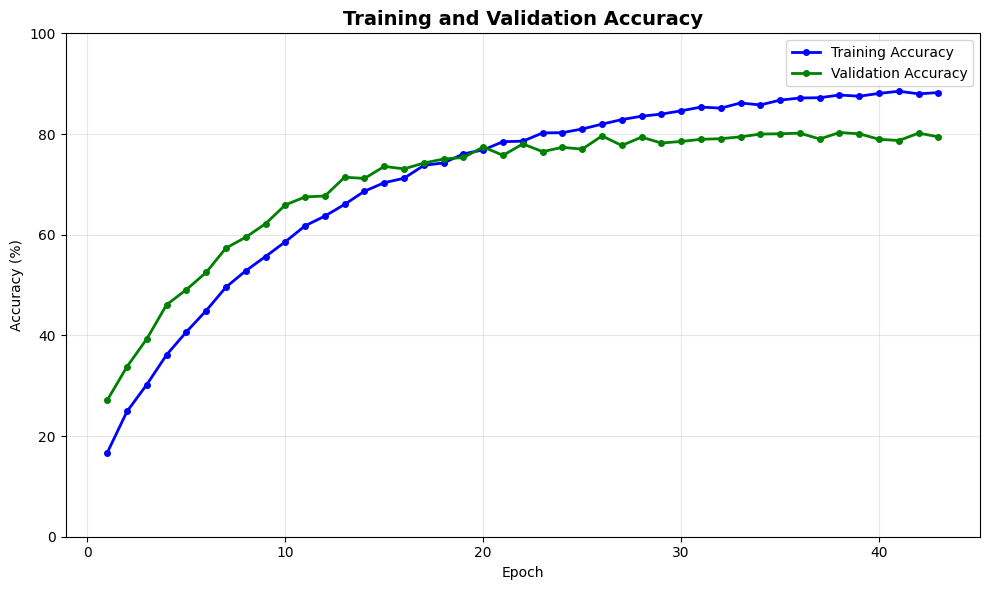

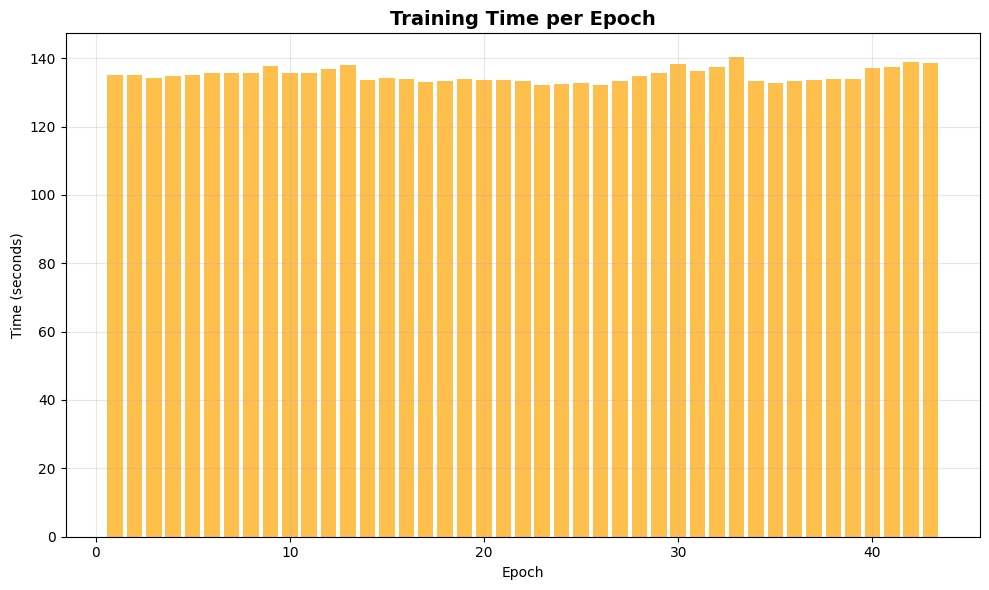

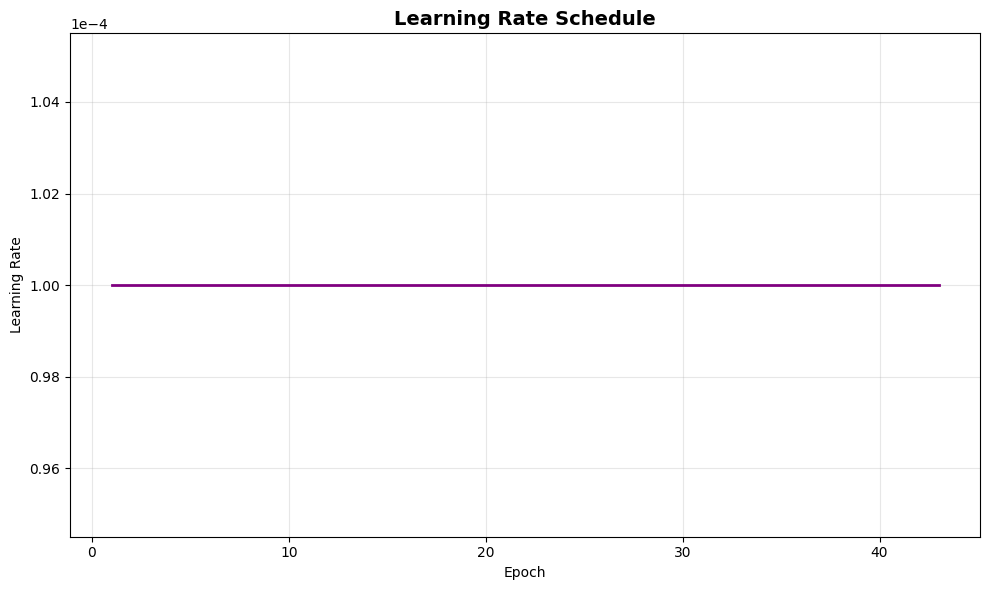

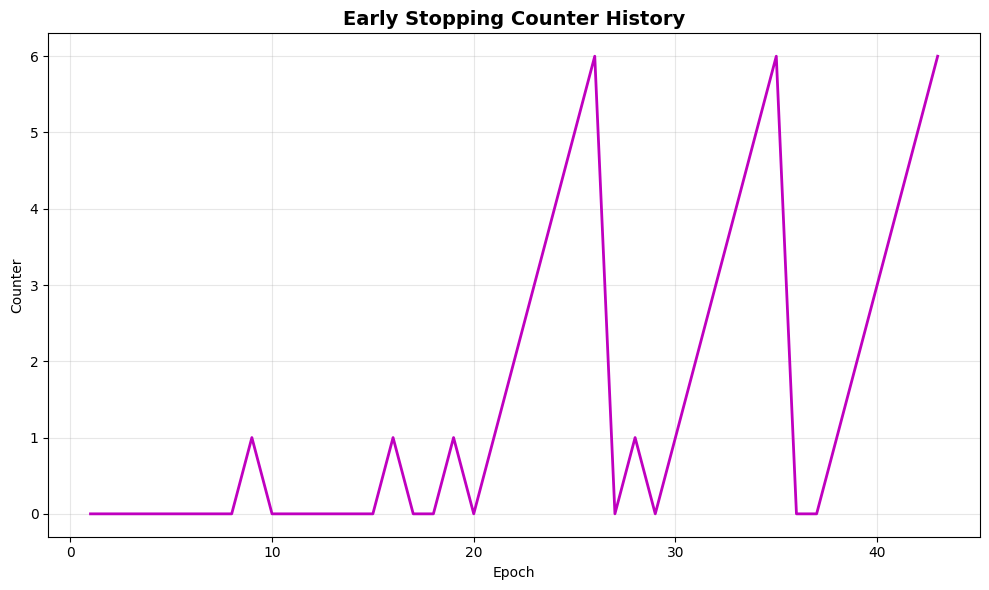


🛑 Early Stopping Analysis:
Early stopping triggered at epoch 43/50.
Epochs saved: 7
Time saved: ~15.7 minutes
Efficiency gain: 14.0%

📈 Detailed Training Statistics:
- Loss Reduction: 2.0284 → 0.2831 (86.0% improvement)
- Best Accuracy: 80.29% (Epoch 38)
- Total Training Time: 96.75 minutes
- Average Time per Epoch: 134.99s
- Fastest Epoch: 132.00s
- Slowest Epoch: 140.24s
- Early Stopping Counter History: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 2, 3, 4, 5, 6, 0, 1, 0, 1, 2, 3, 4, 5, 6, 0, 0, 1, 2, 3, 4, 5, 6]

📋 Training Metrics Table (Last 5 Epochs):
 Epoch  Train_Loss  Val_Loss  Val_Accuracy  Epoch_Time  Learning_Rate  ES_Counter
    39      0.3091    0.6550         80.05      133.77         0.0001           2
    40      0.2904    0.6740         78.95      137.16         0.0001           3
    41      0.2856    0.7373         78.70      137.28         0.0001           4
    42      0.2970    0.6757         80.17      138.88         0.0001           5
    43

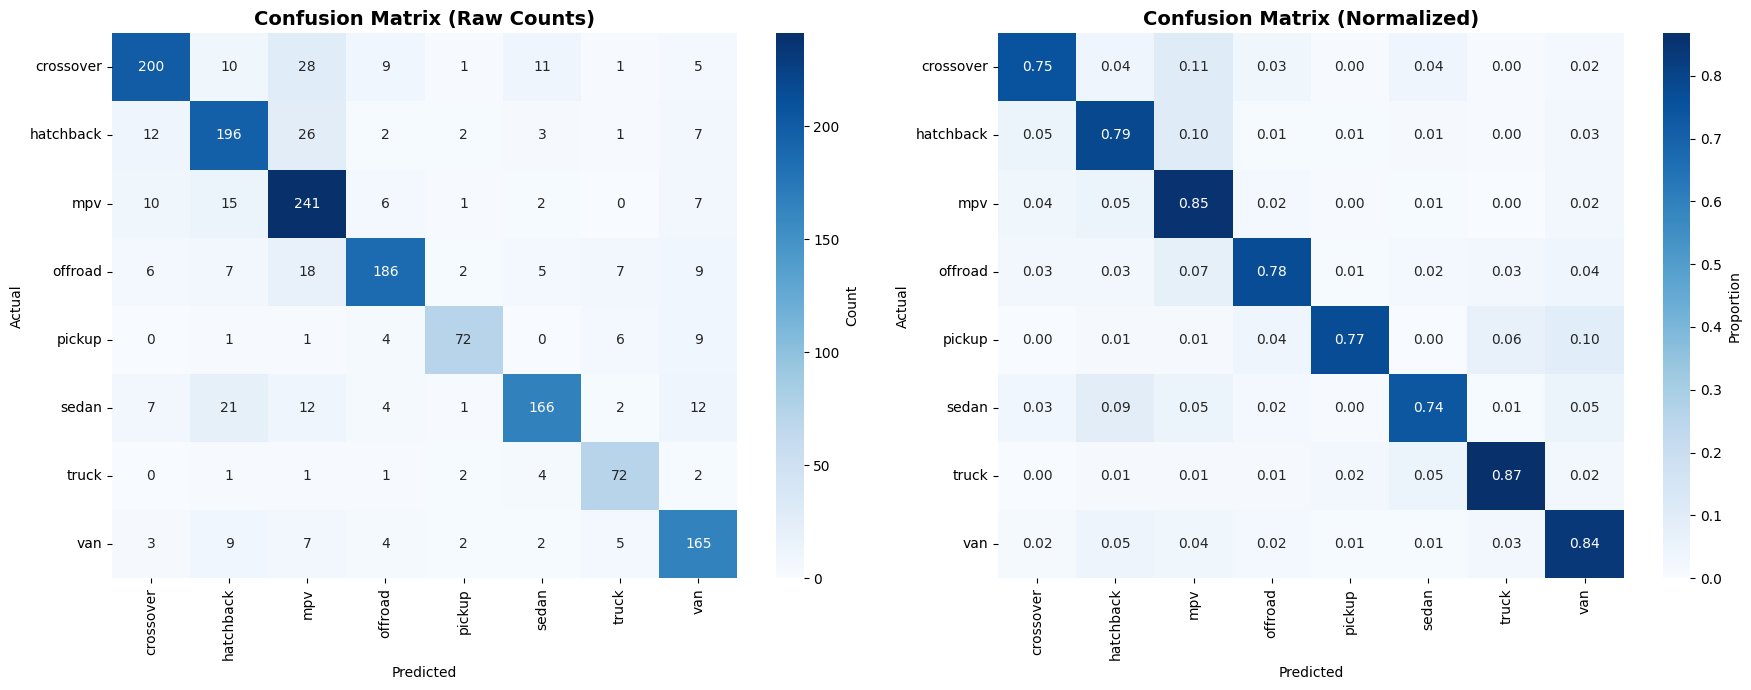


📊 Detailed Classification Report:
              precision    recall  f1-score   support

   crossover     0.8403    0.7547    0.7952       265
   hatchback     0.7538    0.7871    0.7701       249
         mpv     0.7216    0.8546    0.7825       282
     offroad     0.8611    0.7750    0.8158       240
      pickup     0.8675    0.7742    0.8182        93
       sedan     0.8601    0.7378    0.7943       225
       truck     0.7660    0.8675    0.8136        83
         van     0.7639    0.8376    0.7990       197

    accuracy                         0.7944      1634
   macro avg     0.8043    0.7986    0.7986      1634
weighted avg     0.8010    0.7944    0.7948      1634


⚖️ Class Imbalance Impact Analysis:

📈 Class Group Performance:
Minority Classes (4): ['pickup', 'sedan', 'truck', 'van']
Average Accuracy: 80.43%
Majority Classes (4): ['crossover', 'hatchback', 'mpv', 'offroad']
Average Accuracy: 79.29%
Performance Gap: 1.14% (Minority better)


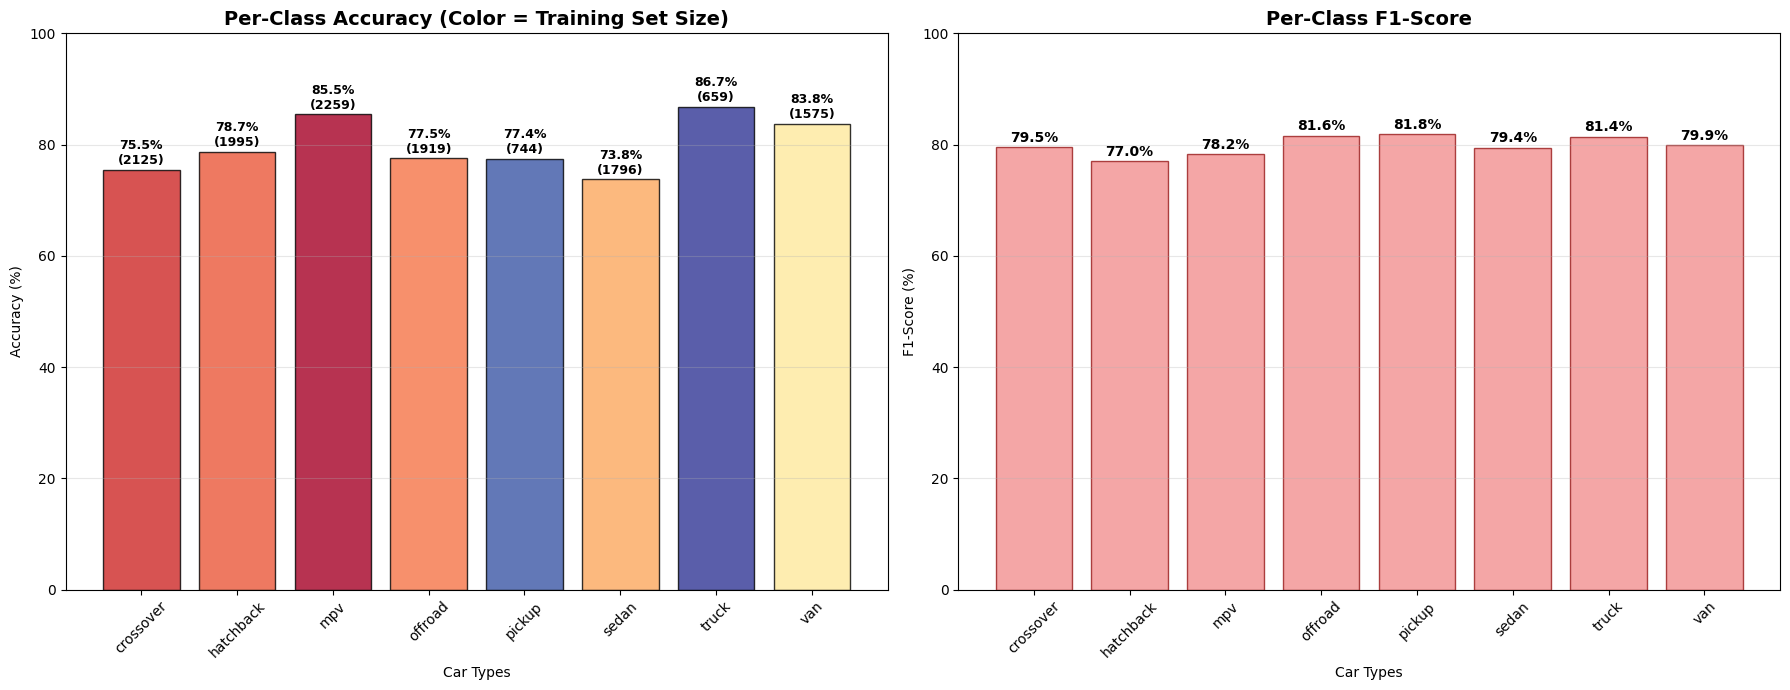


🛑 Early stopping summary saved to: models/classification/reports/early_stopping_summary_20250623_224852.json

💾 Training history saved to: models/classification/reports/training_history_20250623_224852.csv
📊 Class performance saved to: models/classification/reports/class_performance_20250623_224852.csv
🎯 Best model saved to: models/classification/results/carvit_model_20250623_210845.pth
🏆 Best accuracy model saved to: models/classification/results/carvit_model_20250623_210845_best_acc.pth

🎉 Training Analysis Complete!
🎯 Final Summary:
- Training completed in 43 epochs (planned: 50)
- Best validation accuracy: 80.29%
- Early stopping: Activated
- Total training time: 96.75 minutes
- Time saved by early stopping: 15.7 minutes
- Class imbalance: Moderate (ratio: 3.43x)
- Model saved with best validation loss: 0.651589


In [7]:
# Generate the full report
from models.classification.train_classification_eval import TrainingEvaluation

report = TrainingEvaluation(trainer, CONFIG, training_results)

report.full_report()

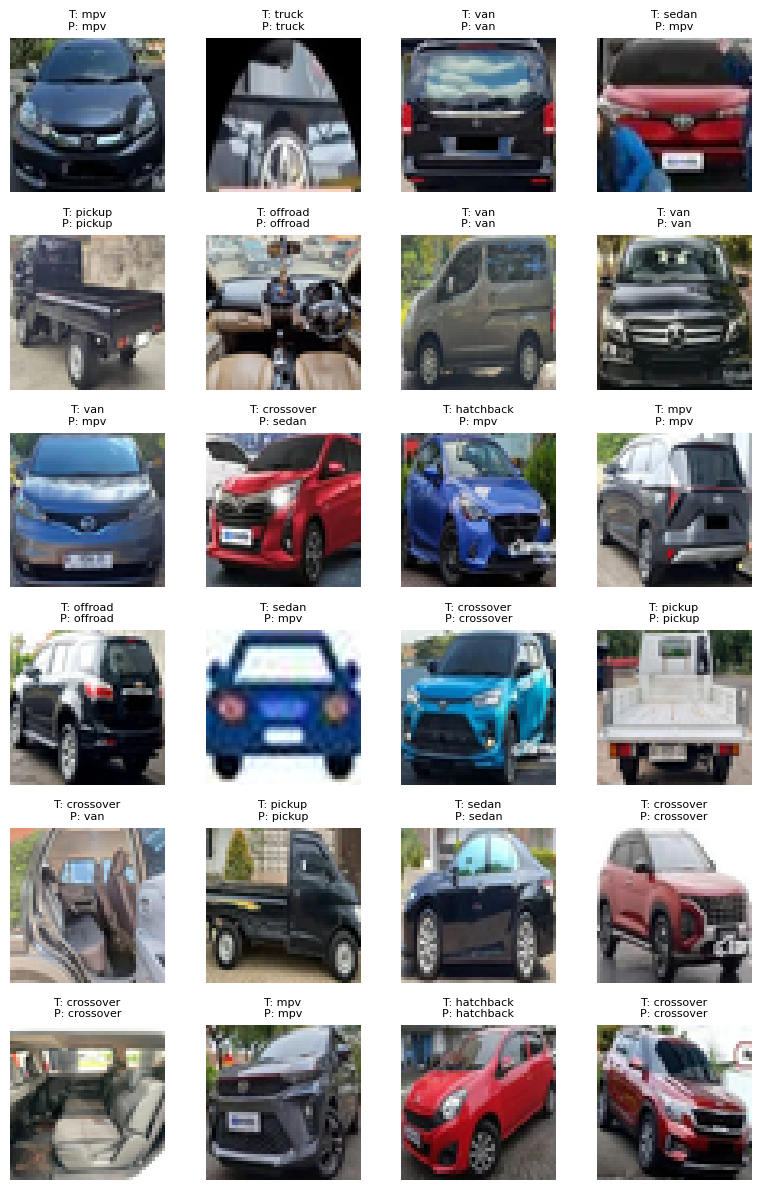

Test Accuracy: 75.00% (18/24)


In [8]:
# Test the classification model test images and display predictions
import os

from models.classification.test_classification import CarClassificationTester

test_dir = f"{DATASET_DIR}/test"
class_names = [
    d for d in sorted(os.listdir(test_dir)) if os.path.isdir(os.path.join(test_dir, d))
]
tester = CarClassificationTester(
    test_dir=test_dir,
    class_names=class_names,
    model_path=None,
    grid_rows=6,
    grid_cols=4,
    num_classes=CONFIG["num_classes"],
)

tester.plot_predictions()